<div align="center">

# Outlier Confidence

</div>
<br>

The last notebook showed some advanced ways to use thresholding in `PyThresh`, but there are also other utilities available.
Unsupervised tasks are difficult in that they often have no examples with which to compare to. This can present issues when the results require a certain level of confidence to be accepted. Thankfully, a confidence interval for the threshold point can be calculated and return back points that fall within this level of confidence as potentially uncertain with respect to their class (inlier/outliers). These points, depending on the criterion, can be assigned to one of the classes or kept as a separate class of their own.

For a more in-depth look at what is being done visit [Thresholding Confidence](https://pythresh.readthedocs.io/en/latest/confidence.html)


# Let's get started!

To begin, we need to install pythresh to work with the notebook



In [ ]:
!pip install pythresh

We can now import a dataset to work with

In [23]:
import os
from scipy.io import loadmat
from pyod.utils.utility import standardizer

file = os.path.join('data', 'musk.mat')
mat = loadmat(file)

X = mat['X'].astype(float)
y = mat['y'].ravel().astype(int)

X = standardizer(X)

Now lets apply our confidence thresholding method.

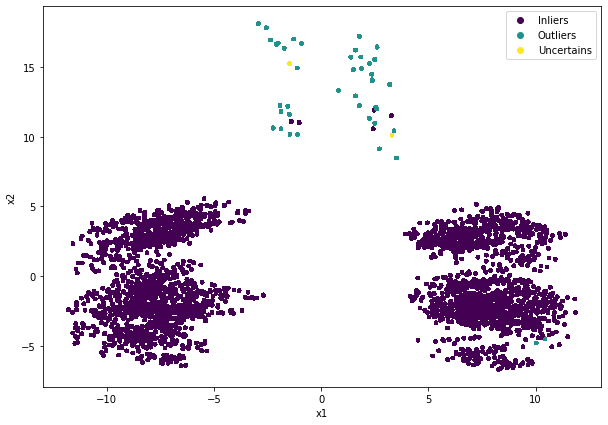

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pythresh.thresholds.iqr import IQR
from pythresh.utils.conf import CONF

def plotter(X, y):

    fig = plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=8, antialiased=False)
    handles, _ = scatter.legend_elements()
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(handles = handles, labels=['Inliers', 'Outliers', 'Uncertains'])
    plt.show()


# Initialize and fit OD and thresholder
od = IForest(random_state=1234)
od.fit(X)
scores = od.decision_scores_

thresh = IQR()

# Alpha is set so that we get a 95% confidence level
# Split is set to 0.2 for sample sizes
# N_test runs 100 bootstrap tests
confidence = CONF(thresh, alpha=0.05, split=0.2, n_test=100)
unc_idx = confidence.eval(scores)

thresh.fit(scores)

fit_labels = thresh.labels_
fit_labels[unc_idx] = 2

# Let's plot our results and see what we get
decomp = PCA(n_components=2)

X_decomp = decomp.fit_transform(X)
plotter(X_decomp, fit_labels)

<br>

From what we can see above the `Uncertains` captured two points that fall within the 95% confidence of not fitting into either the inlier or outlier class. In the example above it is easy to see that these two points are outliers, but not all datasets are this easy to visualize the two distinct classes. So lets see this for a more difficult dataset.

In [25]:
import os
from scipy.io import loadmat
from pyod.utils.utility import standardizer

file = os.path.join('data', 'cardio.mat')
mat = loadmat(file)

X = mat['X'].astype(float)
y = mat['y'].ravel().astype(int)

X = standardizer(X)

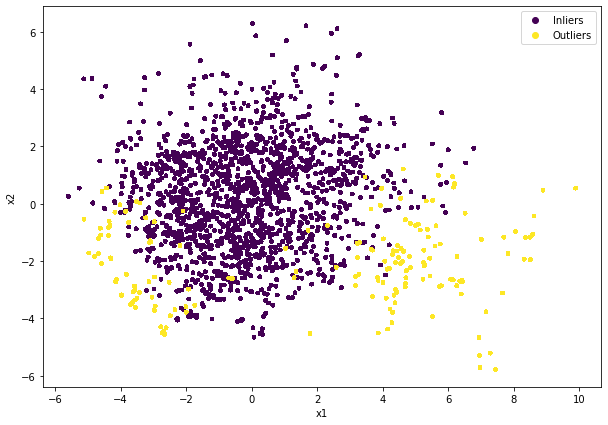

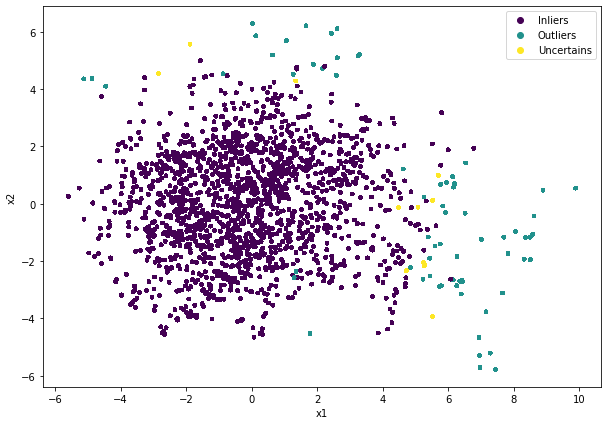

In [26]:
# To get a sense lets see the real labels first
decomp = PCA(n_components=2)

X_decomp = decomp.fit_transform(X)

plotter(X_decomp, y)

# Now lets apply the OD, thresholder and confidence test
od = IForest(random_state=1234)
od.fit(X)
scores = od.decision_scores_

thresh = IQR()

# Alpha is set so that we get a 99% confidence level
# Split is set to 0.1 for sample sizes
# N_test runs 100 bootstrap tests
confidence = CONF(thresh, alpha=0.01, split=0.1, n_test=100)
unc_idx = confidence.eval(scores)

thresh.fit(scores)

fit_labels = thresh.labels_
fit_labels[unc_idx] = 2

plotter(X_decomp, fit_labels)


From what we can see, at 99% confidence interval there are a few `Uncertains`. However, it is important to note that thresholding is dependent on the quality of the outlier detection method. Hence, even with applying a confidence test, the benefits here were less than that of a well fit outlier detector and thresholder. "But how can I find the best fitting outlier thresholder combination?" Well, check out the next notebook for exactly that!